# **STANDARD NOTEBOOK TO GET RESULTS**

## 1. Clean the Data

In [24]:
import pandas as pd 
import process
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.dropna() # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

## 2. Run the code

Once the run is completed, you have: 
* the overall return -> overall return
* the PnL associated to the strategy
* the daily PnL associated to the strategy
* the Sharpe Ratio associated to the strategy

In [26]:
import warnings 
from PyFolioC import PyFolioC
warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

##################################################################### PARAMETERS #####################################################################
historical_data = df_cleaned
number_of_repetitions = 10
lookback_window = [1957,2007] 
evaluation_window = 5
number_of_clusters = 38
cov_method = 'SPONGE'
sigma = 0.01
eta = 0.01

beta = 0.95
K = 4  # Number of fold for the cross validation
######################################################################################################################################################

##################################################################### PORTFOLIO ######################################################################
portfolio = PyFolioC(number_of_repetitions=number_of_repetitions, historical_data=historical_data, lookback_window=lookback_window, evaluation_window=evaluation_window, number_of_clusters=number_of_clusters, sigma=sigma, eta=eta, short_selling=True, cov_method=cov_method)


## year 2008-2009 ==> 2007:2262 if evaluation_window == 2
## year 2008-2009 ==> 2007:2265 if evaluation_window == 5
## year 2012-2013 ==> 3016:3265
## year 2018-2019 ==> 4524:4774
## year 2016-2019 ==> 4021:4774
## year 2010-2020 ==> 2512:5279 (we go until 5277 to have a multiple of 5 for the difference)

In [27]:
overall_return, PnL, portfolio_value, daily_PnL = portfolio.sliding_window(654) ## 150 --> 3 years

step 1/654, portfolio value: 1.0151
step 2/654, portfolio value: 1.0225
step 3/654, portfolio value: 1.0248
step 4/654, portfolio value: 1.0226
step 5/654, portfolio value: 1.0238
step 6/654, portfolio value: 1.0168
step 7/654, portfolio value: 0.9847
step 8/654, portfolio value: 1.0131
step 9/654, portfolio value: 0.9901
step 10/654, portfolio value: 0.9800
step 11/654, portfolio value: 0.9809
step 12/654, portfolio value: 1.0091
step 13/654, portfolio value: 1.0143
step 14/654, portfolio value: 1.0071
step 15/654, portfolio value: 1.0094
step 16/654, portfolio value: 1.0046
step 17/654, portfolio value: 1.0049
step 18/654, portfolio value: 1.0109
step 19/654, portfolio value: 1.0250
step 20/654, portfolio value: 1.0158
step 21/654, portfolio value: 1.0138
step 22/654, portfolio value: 1.0064
step 23/654, portfolio value: 0.9992
step 24/654, portfolio value: 0.9864
step 25/654, portfolio value: 0.9858
step 26/654, portfolio value: 0.9835
step 27/654, portfolio value: 0.9705
step 28/65

ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (381 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        

## 3. Save the results to csv files (APPLY THE CELLS ONLY ONCE AS IT CREATES 3 FILES !!)

In [21]:
year = '2008-2020'
clustering_method = 'SL_short_selling'

## process.save_to_csv(year=year, clustering_method=clustering_method)

df_daily = pd.DataFrame(daily_PnL, columns=['Daily PnL'])

df_daily.to_csv(f'daily_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

df_PnL = pd.DataFrame(PnL, columns=['PnL'])

df_PnL.to_csv(f'PnL_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

df_overall_return = pd.DataFrame(overall_return.values, columns=['Return'])

df_overall_return.to_csv(f'Overall_return_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

## 4. Get SP500 data for comparison

In [17]:
start_date = '2008-01-01'
end_date = '2020-12-27'
year = '2008-2020'
clustering_method = 'Signed_Laplacian_Short_selling'

sp500_PnL = process.get_sp500_PnL(start_date, end_date)
print(len(sp500_PnL))
print(len(overall_return))

[*********************100%%**********************]  1 of 1 completed
3270
3270


## 5. Plot Portfolio Cumulative PnL vs SP500 Cumulative PnL

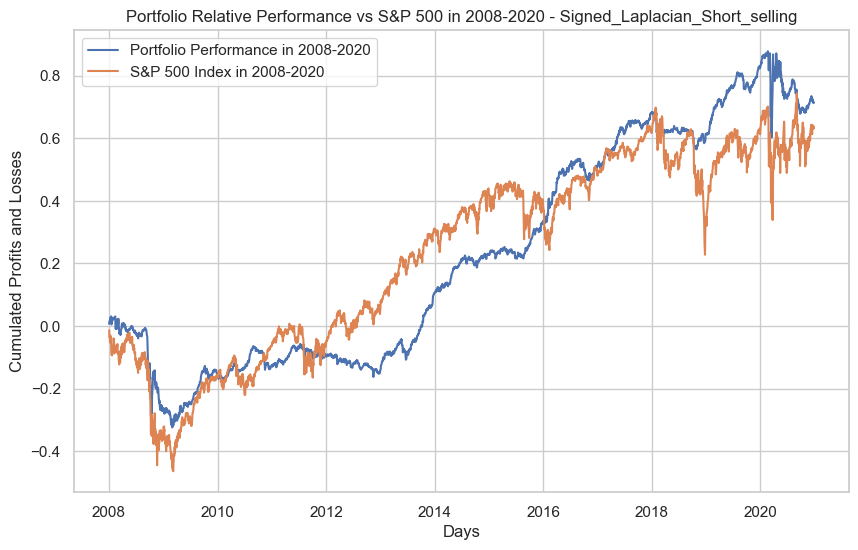

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the cumulative returns
portfolio_cumulative = pd.DataFrame(index = sp500_PnL.index, columns=[f'Portfolio Performance in {year}'], data=PnL)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=portfolio_cumulative)
sns.lineplot(data=sp500_PnL.cumsum(), label=f'S&P 500 Index in {year}')
plt.xlabel('Days')
plt.ylabel('Cumulated Profits and Losses')
plt.title(f'Portfolio Relative Performance vs S&P 500 in {year} - {clustering_method}')
plt.legend()
plt.show()

# 6. Plot portfolio value alone

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)

portfolio_value = pd.DataFrame(index = sp500_PnL.index, columns=[f'Portfolio Value in {year}'], data=portfolio_value)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer la PnL cumulative avec seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(portfolio_value, color='blue')

# Ajouter des titres et des légendes
plt.title(f'Portfolio Value of Time for an Initial Investment of $1 in {year} - {clustering_method}')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')

# Afficher le graphique
plt.show()

ValueError: Shape of passed values is (655, 1), indices imply (3270, 1)

# 7. Barplot Daily PnL vs SP500

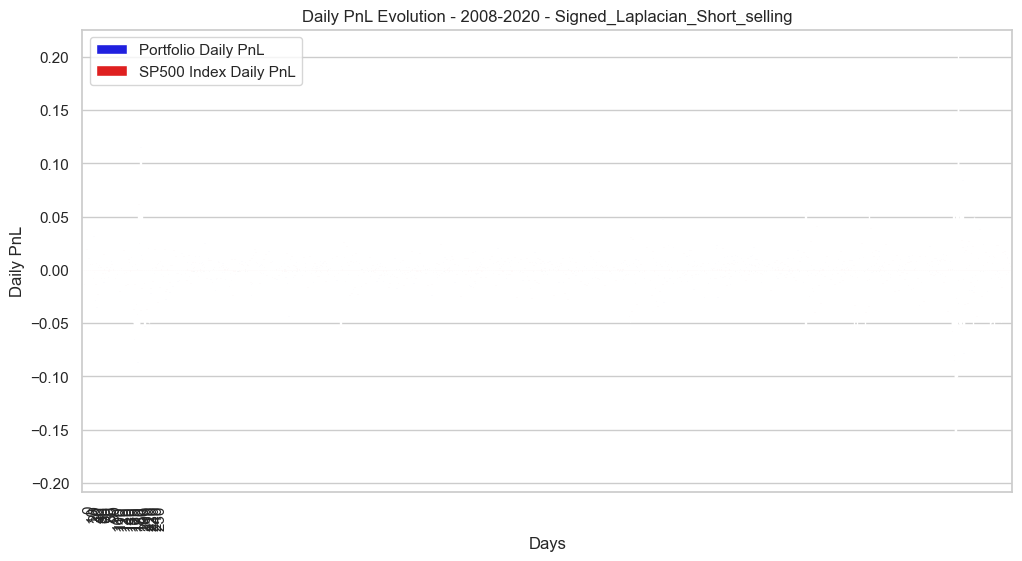

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)
days = np.arange(1, len(daily_PnL) + 1)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer l'évolution quotidienne de la PnL sous forme de diagramme à barres avec seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=days, y=daily_PnL, color='blue', width=0.8, label='Portfolio Daily PnL')  # Ajustez la largeur ici
ax = sns.barplot(x=days, y=sp500_PnL, color='red', width=0.8, label='SP500 Index Daily PnL')

# Rotation des étiquettes de l'axe des abscisses de 45 degrés avec un ajustement
ax.set_xticks(np.arange(0,251,10))
ax.set_xticklabels(ax.get_xticks(), rotation=90, ha='right', rotation_mode='anchor')

# Ajouter des titres et des légendes
plt.title(f'Daily PnL Evolution - {year} - {clustering_method}')
plt.xlabel('Days')
plt.ylabel('Daily PnL')
plt.legend()

# Afficher le graphique
plt.show()

# 8. Plot everything (SPONGE vs Signed Laplacian vs SP500)

In [73]:
sp500_PnL.iloc[:-2]

Date
2014-01-02   -0.007520
2014-01-03   -0.000997
2014-01-06   -0.003001
2014-01-07    0.004968
2014-01-08   -0.000222
                ...   
2014-12-22    0.005017
2014-12-23    0.000374
2014-12-24   -0.000742
2014-12-26    0.002422
2014-12-29    0.001593
Name: Daily PnL, Length: 250, dtype: float64

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PnL_SPONGE_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_SPONGE_5_2.csv')
PnL_SPONGE_1 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2018/PnL_2018_SPONGE_1.csv')
PnL_SPONGE_sym_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_SPONGE_sym_5_2.csv')
PnL_SL_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_signed_laplacian_5_2.csv')

#PnL_SPONGE_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_SPONGE_5_2.csv')
#PnL_SPONGE_sym_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_SPONGE_sym_5_2.csv')
#PnL_SL_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_signed_laplacian_5_2.csv')

# Calculate the cumulative returns
portfolio_cumulative_SL_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'Signed Laplacian Portfolio Performance in {year}'], data=PnL_SL_5.values)
portfolio_cumulative_SPONGE_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_5.values)
portfolio_cumulative_SPONGE_1 = pd.DataFrame(index=sp500_PnL.index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_1.values)
portfolio_cumulative_SPONGE_sym_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'Symmetric SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_sym_5.values)

# portfolio_cumulative_SL_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'Signed Laplacian Portfolio Performance in {year}'], data=PnL_SL_5_2.values)
# portfolio_cumulative_SPONGE_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_5_2.values)
# portfolio_cumulative_SPONGE_sym_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'Symmetric SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_sym_5_2.values)

# Combine dataframes for seaborn plotting
## combined_df = pd.concat([portfolio_cumulative_SL_5, portfolio_cumulative_SL_5_2, portfolio_cumulative_SPONGE_5, portfolio_cumulative_SPONGE_5_2, portfolio_cumulative_SPONGE_sym_5, portfolio_cumulative_SPONGE_sym_5_2, sp500_PnL.iloc[:-1].cumsum()], axis=1)
combined_df = pd.concat([portfolio_cumulative_SL_5, portfolio_cumulative_SPONGE_5, portfolio_cumulative_SPONGE_sym_5, sp500_PnL.iloc[:-2].cumsum()], axis=1)
combined_df.columns = [f'Signed Laplacian - Evaluation window {evaluation_window}', f'SPONGE - Evaluation window {evaluation_window}', f'SPONGE_sym - Evaluation window {evaluation_window}', f'S&P 500 Index in {year}']

# Set Seaborn style
sns.set(style="darkgrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(15, 8))
sns.lineplot(data=combined_df, palette=['blue', 'red', 'orange', 'green'], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulated Profits and Losses')
plt.title(f'Portfolio Relative Performance vs S&P 500 in {year}')
plt.legend()
plt.show()

ValueError: Shape of passed values is (250, 1), indices imply (855, 1)